# Agentic Analysis
This is an analysis of the KYB AI Agent output data. 

In [1]:
import pandas as pd
import numpy as np
import os
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

conn_params = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT", "5432"),
}

def fetch_kyb_data_with_entity_info():
    """
    Fetch KYB job data with client/contractor information and entity type classification
    """
    query = """
    SELECT c.id as client_id,
           cr.id as contractor_id,
           e.legal_name,
           j.*
    FROM raw_data.raw_kyb_job j
    LEFT JOIN raw_data.raw_client c ON j.entity_id = c.entity_id 
    LEFT JOIN raw_data.raw_entity e ON j.entity_id = e.id
    LEFT JOIN raw_data.raw_contractor cr ON j.entity_id = cr.entity_id
    """
    
    with psycopg2.connect(**conn_params) as conn:
        with conn.cursor() as cur:
            cur.execute(query)
            rows = cur.fetchall()
            columns = [desc[0] for desc in cur.description]
    
    # Create DataFrame
    df = pd.DataFrame(rows, columns=columns)
    
    # Add entity type classification
    df['entity_type'] = df.apply(lambda row: 
        'Business Contractor' if pd.notna(row['contractor_id']) else 'Client', 
        axis=1)
    
    # Add entity identifier (use contractor_id if available, otherwise client_id)
    df['entity_identifier'] = df.apply(lambda row: 
        row['contractor_id'] if pd.notna(row['contractor_id']) else row['client_id'], 
        axis=1)
    
    print(f"KYB Data with Entity Info: {len(df)} rows fetched")
    print(f"Entity Type Distribution:")
    print(df['entity_type'].value_counts())
    
    return df

# Fetch the updated data
kyb_job_df = fetch_kyb_data_with_entity_info()

# Display the new structure
print("\nDataFrame columns:")
print(kyb_job_df.columns.tolist())

print("\nFirst few rows with new columns:")
display_cols = ['id', 'entity_id', 'legal_name', 'client_id', 'contractor_id', 'entity_type', 'entity_identifier', 'decision', 'risk_score']
print(kyb_job_df[display_cols].head())

KYB Data with Entity Info: 15 rows fetched
Entity Type Distribution:
entity_type
Business Contractor    8
Client                 7
Name: count, dtype: int64

DataFrame columns:
['client_id', 'contractor_id', 'legal_name', 'id', 'job_id', 'entity_id', 'status', 'decision', 'risk_score', 'justification', 'llm_analysis', 'llm_model', 'components', 'created_at', 'updated_at', 'entity_type', 'entity_identifier']

First few rows with new columns:
   id  entity_id                                         legal_name  \
0  12      73390            R L FERREIRA CONSULTORIA COMERCIAL LTDA   
1  15      73449                 53949101 CATHERINE TAMARA CASTILLO   
2  11      73369                        MARIANA DA SILVA ASSIS LTDA   
3  13      73279                    RDS Abreu Marketing Promocional   
4  17      73465  VALERIA BATISTA PEREIRA DESENVOLVIMENTO DE SOF...   

   client_id  contractor_id          entity_type  entity_identifier  \
0        NaN        67477.0  Business Contractor         

In [2]:
print(kyb_job_df.describe(include='all'))

          client_id  contractor_id                               legal_name  \
count      7.000000       8.000000                                       15   
unique          NaN            NaN                                       15   
top             NaN            NaN  R L FERREIRA CONSULTORIA COMERCIAL LTDA   
freq            NaN            NaN                                        1   
mean    5851.714286   67434.625000                                      NaN   
min     5794.000000   67349.000000                                      NaN   
25%     5831.000000   67374.750000                                      NaN   
50%     5862.000000   67427.500000                                      NaN   
75%     5875.500000   67488.750000                                      NaN   
max     5893.000000   67533.000000                                      NaN   
std       38.077615      73.151384                                      NaN   

               id                                jo

In [3]:
print(kyb_job_df.dtypes)

client_id                   float64
contractor_id               float64
legal_name                   object
id                            int64
job_id                       object
entity_id                     int64
status                       object
decision                     object
risk_score                   object
justification                object
llm_analysis                 object
llm_model                    object
components                   object
created_at           datetime64[ns]
updated_at           datetime64[ns]
entity_type                  object
entity_identifier           float64
dtype: object


In [4]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Basic Data Overview

In [5]:
# 1. BASIC DATA OVERVIEW
print("\n1. BASIC DATA OVERVIEW")
print("-" * 40)

print(f"Total KYB Jobs Analyzed: {len(kyb_job_df)}")
print(f"Date Range: {kyb_job_df['created_at'].min()} to {kyb_job_df['created_at'].max()}")
print(f"Unique Entities: {kyb_job_df['entity_id'].nunique()}")

# Check for missing values
print(f"\nMissing Values:")
print(kyb_job_df.isnull().sum())

# Convert risk_score to numeric for analysis
kyb_job_df['risk_score_numeric'] = pd.to_numeric(kyb_job_df['risk_score'], errors='coerce')


1. BASIC DATA OVERVIEW
----------------------------------------
Total KYB Jobs Analyzed: 15
Date Range: 2025-08-26 00:12:18.443536 to 2025-09-09 04:56:31.128588
Unique Entities: 15

Missing Values:
client_id            8
contractor_id        7
legal_name           0
id                   0
job_id               0
entity_id            0
status               0
decision             0
risk_score           0
justification        0
llm_analysis         0
llm_model            0
components           0
created_at           0
updated_at           0
entity_type          0
entity_identifier    0
dtype: int64



2. AI AGENT DECISION ANALYSIS
----------------------------------------
Decision Distribution:
decision
Manual Review    11
Accepted          4
Name: count, dtype: int64
Decision Rate: decision
Manual Review    73.333333
Accepted         26.666667
Name: count, dtype: float64

Risk Score Analysis:
Mean Risk Score: 3.00
Risk Score Range: 1.0 - 5.0
Risk Score Distribution:
risk_score_numeric
1.0    4
3.0    7
5.0    4
Name: count, dtype: int64


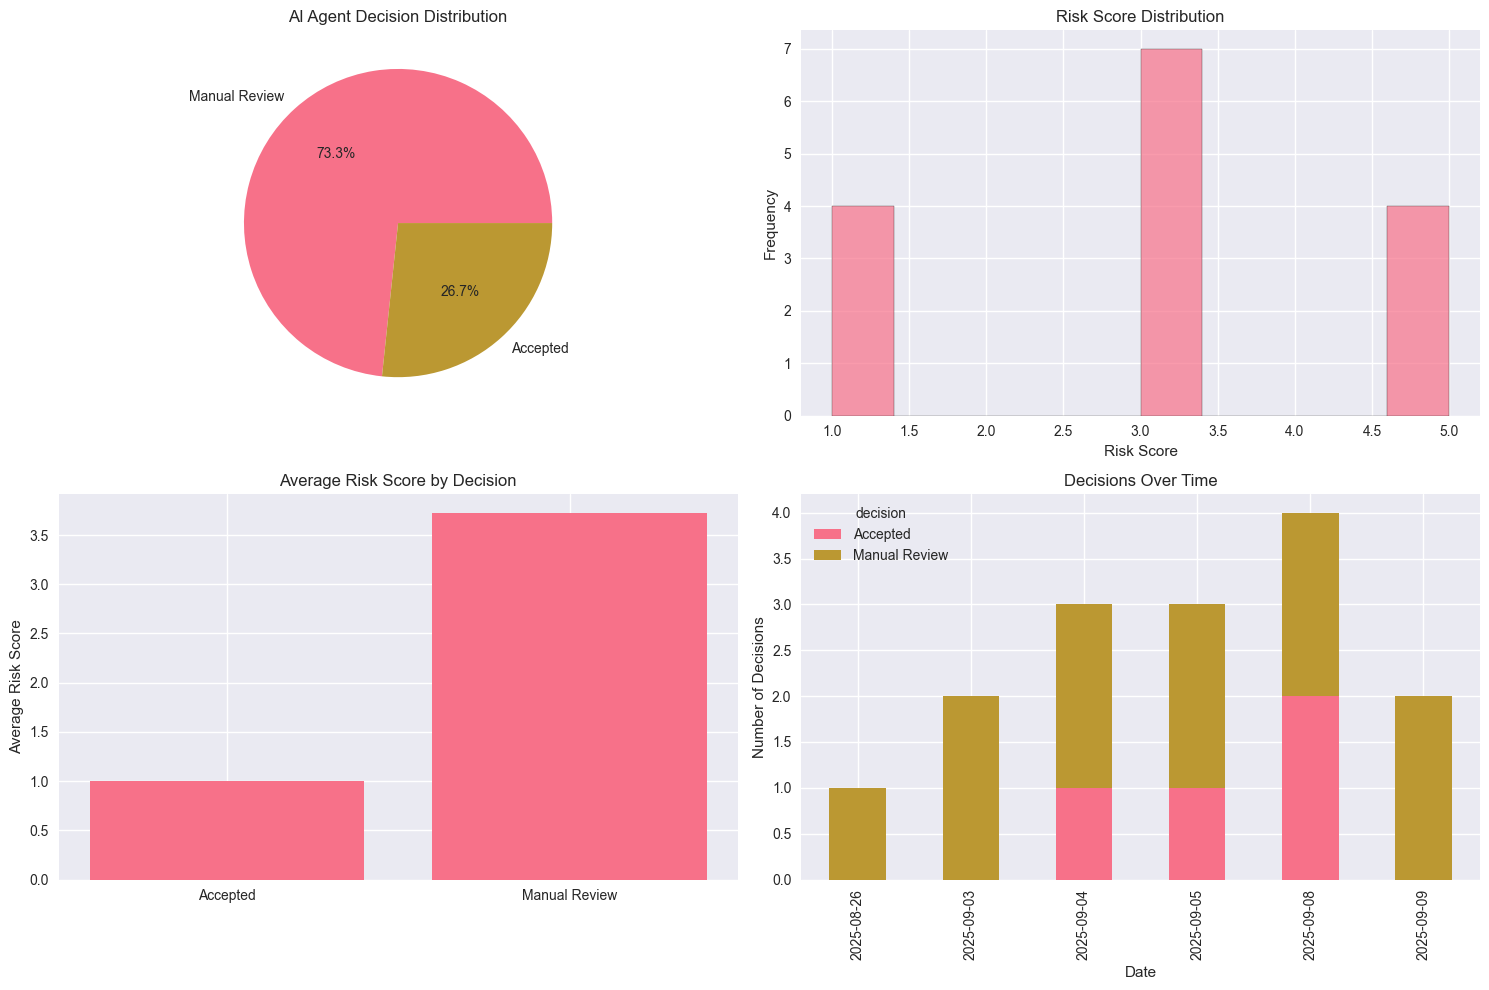

In [6]:
# 2. AI AGENT DECISION ANALYSIS
print("\n2. AI AGENT DECISION ANALYSIS")
print("-" * 40)

# Decision distribution
decision_counts = kyb_job_df['decision'].value_counts()
print("Decision Distribution:")
print(decision_counts)
print(f"Decision Rate: {decision_counts / len(kyb_job_df) * 100}")

# Risk score analysis
print(f"\nRisk Score Analysis:")
print(f"Mean Risk Score: {kyb_job_df['risk_score_numeric'].mean():.2f}")
print(f"Risk Score Range: {kyb_job_df['risk_score_numeric'].min()} - {kyb_job_df['risk_score_numeric'].max()}")
print(f"Risk Score Distribution:")
print(kyb_job_df['risk_score_numeric'].value_counts().sort_index())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Decision distribution
axes[0,0].pie(decision_counts.values, labels=decision_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('AI Agent Decision Distribution')

# Risk score distribution
axes[0,1].hist(kyb_job_df['risk_score_numeric'], bins=10, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Risk Score Distribution')
axes[0,1].set_xlabel('Risk Score')
axes[0,1].set_ylabel('Frequency')

# Decision vs Risk Score
decision_risk = kyb_job_df.groupby('decision')['risk_score_numeric'].mean()
axes[1,0].bar(decision_risk.index, decision_risk.values)
axes[1,0].set_title('Average Risk Score by Decision')
axes[1,0].set_ylabel('Average Risk Score')

# Timeline analysis
kyb_job_df['date'] = kyb_job_df['created_at'].dt.date
daily_decisions = kyb_job_df.groupby(['date', 'decision']).size().unstack(fill_value=0)
daily_decisions.plot(kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_title('Decisions Over Time')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Number of Decisions')

plt.tight_layout()
plt.show()

ENTITY TYPE ANALYSIS
Entity Type Distribution:
  Business Contractor: 8 (53.3%)
  Client: 7 (46.7%)

Decision Analysis by Entity Type:
decision             Accepted  Manual Review  All
entity_type                                      
Business Contractor         4              4    8
Client                      0              7    7
All                         4             11   15

Risk Score Analysis by Entity Type:
                     count      mean       std  min  max
entity_type                                             
Business Contractor      8  2.000000  1.069045  1.0  3.0
Client                   7  4.142857  1.069045  3.0  5.0


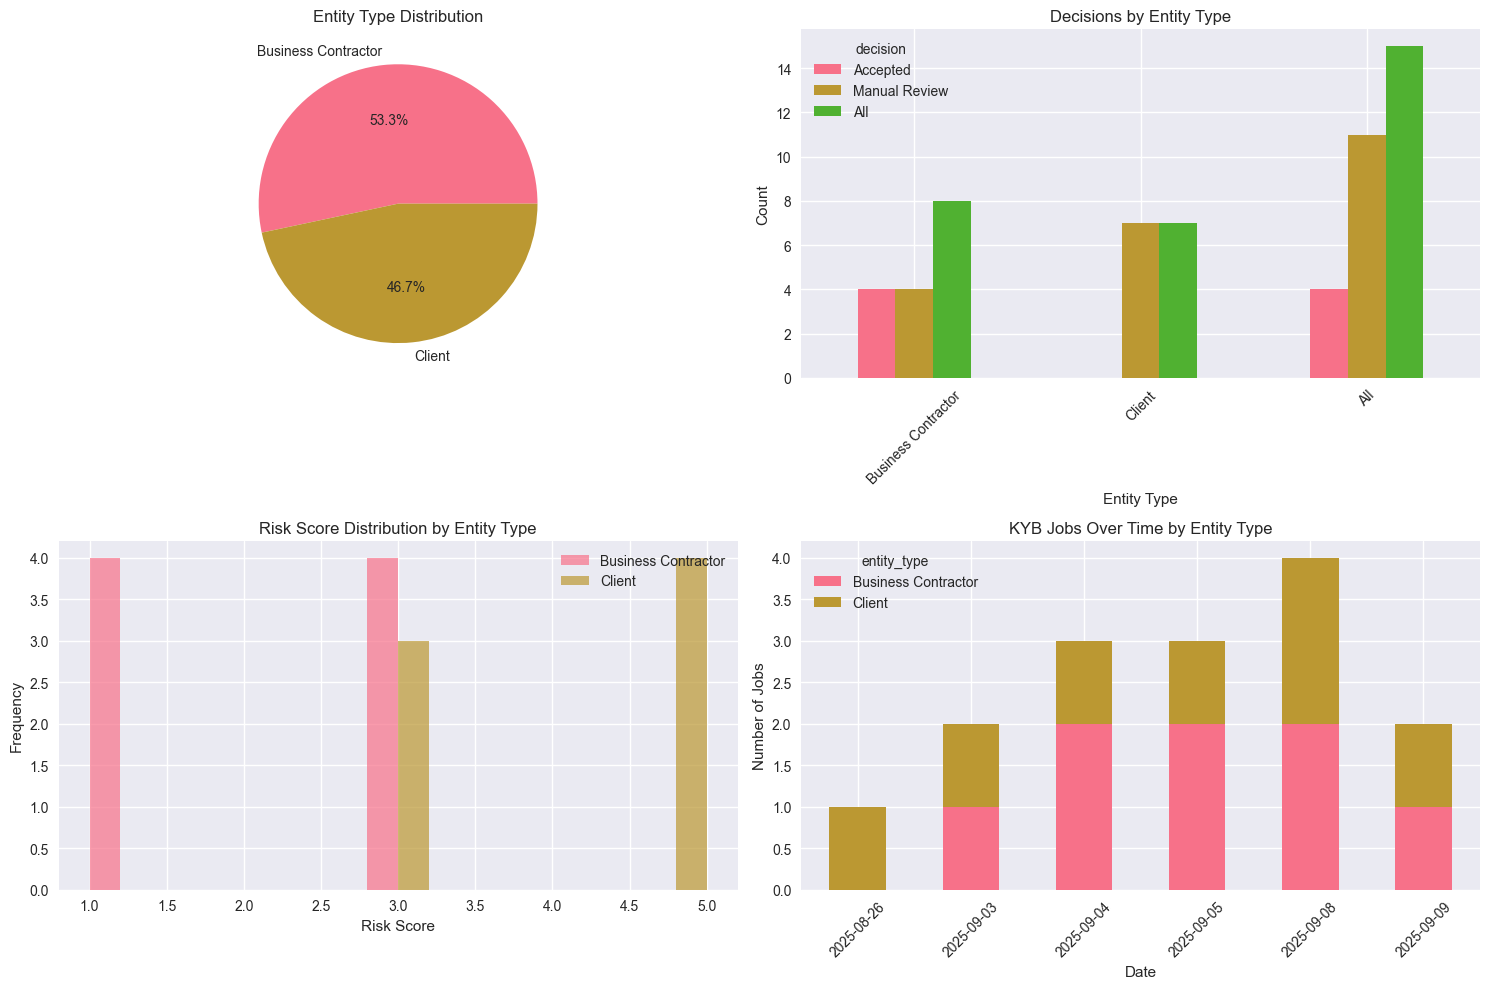

In [7]:
# =============================================================================
# ENHANCED DATA ANALYSIS WITH ENTITY TYPES
# =============================================================================

def analyze_by_entity_type(df):
    """
    Analyze KYB decisions by entity type (Client vs Business Contractor)
    """
    print("=" * 80)
    print("ENTITY TYPE ANALYSIS")
    print("=" * 80)
    
    # Overall distribution
    entity_counts = df['entity_type'].value_counts()
    print(f"Entity Type Distribution:")
    for entity_type, count in entity_counts.items():
        print(f"  {entity_type}: {count} ({count/len(df)*100:.1f}%)")
    
    # Decision analysis by entity type
    print(f"\nDecision Analysis by Entity Type:")
    decision_by_type = pd.crosstab(df['entity_type'], df['decision'], margins=True)
    print(decision_by_type)
    
    # Risk score analysis by entity type
    df['risk_score_numeric'] = pd.to_numeric(df['risk_score'], errors='coerce')
    print(f"\nRisk Score Analysis by Entity Type:")
    risk_by_type = df.groupby('entity_type')['risk_score_numeric'].agg(['count', 'mean', 'std', 'min', 'max'])
    print(risk_by_type)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Entity type distribution
    axes[0,0].pie(entity_counts.values, labels=entity_counts.index, autopct='%1.1f%%')
    axes[0,0].set_title('Entity Type Distribution')
    
    # Decision by entity type
    decision_by_type.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Decisions by Entity Type')
    axes[0,1].set_xlabel('Entity Type')
    axes[0,1].set_ylabel('Count')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Risk score distribution by entity type
    for entity_type in df['entity_type'].unique():
        data = df[df['entity_type'] == entity_type]['risk_score_numeric']
        axes[1,0].hist(data, alpha=0.7, label=entity_type, bins=10)
    axes[1,0].set_title('Risk Score Distribution by Entity Type')
    axes[1,0].set_xlabel('Risk Score')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    
    # Timeline analysis by entity type
    df['date'] = df['created_at'].dt.date
    timeline_data = df.groupby(['date', 'entity_type']).size().unstack(fill_value=0)
    timeline_data.plot(kind='bar', stacked=True, ax=axes[1,1])
    axes[1,1].set_title('KYB Jobs Over Time by Entity Type')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Number of Jobs')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return decision_by_type, risk_by_type

# Run the analysis
decision_analysis, risk_analysis = analyze_by_entity_type(kyb_job_df)

In [8]:
# 3. JUSTIFICATION ANALYSIS
print("\n3. JUSTIFICATION ANALYSIS")
print("-" * 40)

# Extract unique justifications
justifications = kyb_job_df['justification'].value_counts()
print("Top Justifications:")
for justification, count in justifications.head(10).items():
    print(f"  {count:2d}x: {justification}")

# Analyze justification patterns
print(f"\nJustification Patterns:")
justification_words = []
for justification in kyb_job_df['justification']:
    if pd.notna(justification):
        # Extract key terms
        words = re.findall(r'\b[A-Za-z]+\b', justification.lower())
        justification_words.extend(words)

# Most common terms in justifications
common_terms = Counter(justification_words).most_common(15)
print("Most Common Terms in Justifications:")
for term, count in common_terms:
    print(f"  {term}: {count}")

# Justification length analysis
kyb_job_df['justification_length'] = kyb_job_df['justification'].str.len()
print(f"\nJustification Length Statistics:")
print(f"  Mean: {kyb_job_df['justification_length'].mean():.1f} characters")
print(f"  Median: {kyb_job_df['justification_length'].median():.1f} characters")
print(f"  Range: {kyb_job_df['justification_length'].min()} - {kyb_job_df['justification_length'].max()} characters")


3. JUSTIFICATION ANALYSIS
----------------------------------------
Top Justifications:
   7x: Document rules not fully satisfied
   4x: Low risk across checks
   2x: Shareholder risk: high; Document rules not fully satisfied
   1x: Company risk: high; Document rules not fully satisfied
   1x: Representative risk: high

Justification Patterns:
Most Common Terms in Justifications:
  document: 10
  rules: 10
  not: 10
  fully: 10
  satisfied: 10
  risk: 8
  low: 4
  across: 4
  checks: 4
  high: 4
  shareholder: 2
  company: 1
  representative: 1

Justification Length Statistics:
  Mean: 34.7 characters
  Median: 34.0 characters
  Range: 22 - 58 characters


In [9]:
# 4. LLM ANALYSIS EXPLORATION
print("\n4. LLM ANALYSIS EXPLORATION")
print("-" * 40)

# LLM Model usage
llm_models = kyb_job_df['llm_model'].value_counts()
print("LLM Model Usage:")
print(llm_models)

# Analyze LLM analysis content
print(f"\nLLM Analysis Sample (First 3):")
for i, analysis in enumerate(kyb_job_df['llm_analysis'].head(3)):
    print(f"\n--- Analysis {i+1} ---")
    print(analysis[:500] + "..." if len(analysis) > 500 else analysis)

# Extract risk classifications from LLM analysis
risk_classifications = []
for analysis in kyb_job_df['llm_analysis']:
    if pd.notna(analysis):
        # Look for risk level mentions
        risk_match = re.search(r'(low|moderate|high|medium)\s*risk', analysis.lower())
        if risk_match:
            risk_classifications.append(risk_match.group(1))
        else:
            risk_classifications.append('unknown')

risk_class_counts = Counter(risk_classifications)
print(f"\nRisk Classifications Found in LLM Analysis:")
for risk_level, count in risk_class_counts.items():
    print(f"  {risk_level}: {count}")

# LLM analysis length
kyb_job_df['llm_analysis_length'] = kyb_job_df['llm_analysis'].str.len()
print(f"\nLLM Analysis Length Statistics:")
print(f"  Mean: {kyb_job_df['llm_analysis_length'].mean():.1f} characters")
print(f"  Median: {kyb_job_df['llm_analysis_length'].median():.1f} characters")


4. LLM ANALYSIS EXPLORATION
----------------------------------------
LLM Model Usage:
llm_model
gpt-5    15
Name: count, dtype: int64

LLM Analysis Sample (First 3):

--- Analysis 1 ---
Overall assessment: Low risk with an overall risk score of 1 (on a low-to-high scale), consistent with the “Accepted” decision and “Low risk across checks” trigger.

Country/field checks: No country or industry-related risk triggers were observed in the provided screening. The business is categorized as professional services and, within the provided context, no sanctions, adverse media, or high-risk industry indicators were surfaced.

Company-level summary: R L FERREIRA CONSULTORIA COMERCIAL LTD...

--- Analysis 2 ---
Overall assessment: Low risk, score 1 (Accepted). Country/field checks passed with no triggers: the business operates in Brazil as a Microempreendedor Individual (MEI) in design/marketing/communication, a non-sensitive sector with no indications of sanctions exposure or higher-risk activi

In [10]:
# Quick test - install rich first: pip install rich
from rich import print as rprint
from rich.json import JSON
import json

# Test with first components record
first_components = kyb_job_df['components'].iloc[0]
try:
    parsed = json.loads(first_components)
    rprint(JSON.from_data(parsed))
except:
    print("Not valid JSON, displaying as text:")
    print(first_components)

{
  "alloy": {},
  "company": {
    "sources": [
      "https://globalarbitrationreview.com/article/brazilian-retailer-brings-claim-over-billion-dollar-fraud"
    ],
    "risk_level": "low",
    "description": "INSUFFICIENT_CONTEXT: independent corroboration missing. The company R L FERREIRA CONSULTORIA 
COMERCIAL LTDA, based in Sao Paulo, Brazil, is listed as part of the professional services industry. No additional 
information about the company's operations, compliance, or reputation is available in the provided context. There 
are no links to any fraud, regulatory violations, or financial issues in the source. Further investigation would be
required to assess risk more accurately.",
    "risk_factors": []
  },
  "documents": {
    "rules": {
      "R1": {
        "why": "Business representative/controlling person name found in the document set (heuristic 
exact-match).",
        "complies": true,
        "evidence": [
          {
            "file": "CNH-e.pdf.pdf",
            "page": 1,
            "quote": "R LICENSE/PERMISO DE CONDUCCIÓN NOME SOBRENOME *HABILITAÇÃO RAFAEL LEITE FERREIRA 29/06/2009 
DATA, LOCAL UF DE NASCIMENTO 25/05/1987, SAO PAU"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 2,
            "quote": "Enquadramento de Microempresa ME NOME EMPRESARIAL PORTE R L FERREIRA CONSULTORIA COMERCIAL 
LTDA ME LOGRADOURO NÚMERO AVENIDA PAULISTA 1106 COMPLEMENTO BAIRRO/DISTRITO CEP SALA 01 / ANDAR 16 BELA VISTA 
01310914 MUNICÍPIO UF SAO PAULO SP E-MAIL TELEFONE rafa.lferreir@gmail.com 11 974370490 NÚMERO EXIGÊNCIA (S) CNPJ 
SEDE NIRE SEDE SEM EXIGÊNCIA ANTERIOR IDENTIFICAÇÃO DO SIGNATÁRIO/ASSINANTE DO REOUERIMENTO CAPA VALORES RECOLHIDOS
NOME: RAFAEL LEITE FERREIRA Sócio-Administrador DARE Isento DATA ASSINAT"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 3,
            "quote": "CONTRATO SOCIAL DE SOCIEDADE LIMITADA R L FERREIRA CONSULTORIA COMERCIAL LTDA 
Sócio-Administrador RAFAEL LEITE FERREIRA, nacionalidade: brasileira, divorciado(a), n"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 4,
            "quote": ".000,00 (Um mil reais) em moeda corrente do país em nome de RAFAEL LEITE FERREIRA, n° do CPF:
34472426803 integralizado neste ato. SÓCIO № DE"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 5,
            "quote": "particular em via única. SAO PAULO, 12 de setembro de 2024. RAFAEL LEITE FERREIRA 
(Sócio-Administrador) 3/3 Certifico o registro de constitui"
          }
        ],
        "reasoning": "The name 'Rafael Ferreira' appears in multiple documents, confirming the presence of the 
business representative's name."
      },
      "R2": {
        "why": "The document set includes a certificate of incorporation with all required company details.",
        "complies": true,
        "evidence": [
          {
            "file": "Processo Aprovado.pdf",
            "page": 1,
            "quote": "R L FERREIRA CONSULTORIA COMERCIAL LTDA, LIMITADA UNIPESSOAL (M.E.), NIRE 35264928520, CNPJ 
57.275.102/0001-37, 13/09/2024"
          }
        ],
        "reasoning": "The certificate of incorporation provides the company name, type, registration number, date 
of incorporation, and representative details."
      },
      "R3": {
        "why": "The certificate of incorporation includes beneficial ownership details.",
        "complies": true,
        "evidence": [
          {
            "file": "Processo Aprovado.pdf",
            "page": 4,
            "quote": "RAFAEL LEITE FERREIRA, 100% ownership"
          }
        ],
        "reasoning": "The document explicitly states the ownership percentage of the sole shareholder, Rafael Leite
Ferreira."
      },
      "R4": {
        "why": "The document set includes a non-ID document showing the ownership percentage of the beneficial 
owner.",
        "complies": true,
        "evidence": [

In [11]:
# =============================================================================
# COMPONENTS JSON EXTRACTION AND DISPLAY
# =============================================================================

import json
import pandas as pd
from rich import print as rprint
from rich.json import JSON
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.columns import Columns
from rich.tree import Tree

console = Console()

def extract_and_display_components(df, sample_size=3):
    """
    Extract and display components JSON data in a human-friendly format
    """
    print("=" * 80)
    print("COMPONENTS JSON EXTRACTION")
    print("=" * 80)
    
    # Analyze JSON structure
    json_structures = []
    valid_json_count = 0
    
    for idx, components in enumerate(df['components']):
        if pd.notna(components):
            try:
                # Try to parse as JSON
                parsed_data = json.loads(components)
                json_structures.append({
                    'index': idx,
                    'data': parsed_data,
                    'type': type(parsed_data).__name__,
                    'keys': list(parsed_data.keys()) if isinstance(parsed_data, dict) else None
                })
                valid_json_count += 1
            except json.JSONDecodeError:
                # If not JSON, treat as plain text
                json_structures.append({
                    'index': idx,
                    'data': components,
                    'type': 'text',
                    'keys': None
                })
    
    print(f"Valid JSON records: {valid_json_count}/{len(df)}")
    
    # Display sample JSON structures
    console.print("\n[bold green]Sample Components JSON Structures:[/bold green]")
    
    for i, structure in enumerate(json_structures[:sample_size]):
        console.print(f"\n[bold cyan]Record {structure['index'] + 1}:[/bold cyan]")
        
        if structure['type'] == 'dict':
            # Display as rich JSON
            rprint(JSON.from_data(structure['data']))
            
            # Also show as organized table
            create_components_table(structure['data'], structure['index'] + 1)
        else:
            # Display as text
            console.print(Panel(structure['data'], title=f"Record {structure['index'] + 1} - Text Content"))
    
    return json_structures

def create_components_table(components_data, record_num):
    """
    Create a detailed table for components data
    """
    console.print(f"\n[bold yellow]Record {record_num} - Components Breakdown:[/bold yellow]")
    
    for component_name, component_data in components_data.items():
        table = Table(title=f"{component_name.upper()} Component")
        table.add_column("Field", style="cyan", no_wrap=True)
        table.add_column("Value", style="magenta")
        
        if isinstance(component_data, dict):
            for key, value in component_data.items():
                # Handle nested structures
                if isinstance(value, dict):
                    value_str = f"Dict with {len(value)} keys: {list(value.keys())}"
                elif isinstance(value, list):
                    value_str = f"List with {len(value)} items"
                else:
                    value_str = str(value)
                    if len(value_str) > 100:
                        value_str = value_str[:100] + "..."
                
                table.add_row(key, value_str)
        else:
            table.add_row("Data", str(component_data))
        
        console.print(table)

def analyze_components_patterns(json_structures):
    """
    Analyze patterns in the components JSON data
    """
    print("\n" + "=" * 80)
    print("COMPONENTS PATTERN ANALYSIS")
    print("=" * 80)
    
    # Count data types
    type_counts = {}
    all_component_types = set()
    all_fields = set()
    
    for structure in json_structures:
        data_type = structure['type']
        type_counts[data_type] = type_counts.get(data_type, 0) + 1
        
        if structure['keys']:
            all_component_types.update(structure['keys'])
            
            # Get all nested fields
            for component_name in structure['keys']:
                component_data = structure['data'][component_name]
                if isinstance(component_data, dict):
                    all_fields.update(component_data.keys())
    
    print("Data Type Distribution:")
    for data_type, count in type_counts.items():
        print(f"  {data_type}: {count}")
    
    print(f"\nComponent Types Found: {len(all_component_types)}")
    for component in sorted(all_component_types):
        print(f"  - {component}")
    
    print(f"\nAll Fields Found: {len(all_fields)}")
    for field in sorted(all_fields):
        print(f"  - {field}")
    
    # Analyze component frequency
    component_frequency = {}
    field_frequency = {}
    
    for structure in json_structures:
        if structure['keys']:
            for component_name in structure['keys']:
                component_frequency[component_name] = component_frequency.get(component_name, 0) + 1
                
                # Count fields within each component
                component_data = structure['data'][component_name]
                if isinstance(component_data, dict):
                    for field_name in component_data.keys():
                        field_key = f"{component_name}.{field_name}"
                        field_frequency[field_key] = field_frequency.get(field_key, 0) + 1
    
    print(f"\nComponent Frequency:")
    for component, freq in sorted(component_frequency.items(), key=lambda x: x[1], reverse=True):
        print(f"  {component}: {freq} times")
    
    print(f"\nTop Fields:")
    for field, freq in sorted(field_frequency.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {field}: {freq} times")

def extract_specific_component_data(df, component_name):
    """
    Extract data for a specific component across all records
    """
    console.print(f"\n[bold green]Extracting {component_name.upper()} Component Data:[/bold green]")
    
    component_data = []
    
    for idx, components in enumerate(df['components']):
        if pd.notna(components):
            try:
                parsed_data = json.loads(components)
                if component_name in parsed_data:
                    component_data.append({
                        'record_id': idx + 1,
                        'entity_id': df.iloc[idx]['entity_id'],
                        'data': parsed_data[component_name]
                    })
            except:
                continue
    
    console.print(f"Found {component_name} in {len(component_data)} records")
    
    # Display sample data
    for i, data in enumerate(component_data[:3]):
        console.print(f"\n[bold cyan]Record {data['record_id']} (Entity: {data['entity_id']}):[/bold cyan]")
        rprint(JSON.from_data(data['data']))
    
    return component_data

def create_components_summary_table(df, json_structures):
    """
    Create a summary table of components data
    """
    summary_data = []
    
    for i, structure in enumerate(json_structures):
        components_count = len(structure['keys']) if structure['keys'] else 0
        components_list = ', '.join(structure['keys']) if structure['keys'] else 'None'
        
        summary_data.append({
            'Record': i + 1,
            'Entity ID': df.iloc[i]['entity_id'],
            'Components Count': components_count,
            'Components': components_list,
            'Has JSON': 'Yes' if structure['type'] == 'dict' else 'No',
            'Size': len(str(structure['data']))
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    console.print("\n[bold green]Components Summary Table:[/bold green]")
    console.print(summary_df.to_string(index=False))
    
    return summary_df

# Run the analysis
print("Starting Components JSON Analysis...")
json_structures = extract_and_display_components(kyb_job_df, sample_size=3)
analyze_components_patterns(json_structures)
summary_df = create_components_summary_table(kyb_job_df, json_structures)

# Extract specific components (you can modify these based on what you find)
if json_structures and json_structures[0]['keys']:
    # Extract the first component type found
    first_component = list(json_structures[0]['keys'])[0]
    component_data = extract_specific_component_data(kyb_job_df, first_component)

Starting Components JSON Analysis...
COMPONENTS JSON EXTRACTION
Valid JSON records: 15/15


Sample Components JSON Structures:

Record 1:

{
  "alloy": {},
  "company": {
    "sources": [
      "https://globalarbitrationreview.com/article/brazilian-retailer-brings-claim-over-billion-dollar-fraud"
    ],
    "risk_level": "low",
    "description": "INSUFFICIENT_CONTEXT: independent corroboration missing. The company R L FERREIRA CONSULTORIA 
COMERCIAL LTDA, based in Sao Paulo, Brazil, is listed as part of the professional services industry. No additional 
information about the company's operations, compliance, or reputation is available in the provided context. There 
are no links to any fraud, regulatory violations, or financial issues in the source. Further investigation would be
required to assess risk more accurately.",
    "risk_factors": []
  },
  "documents": {
    "rules": {
      "R1": {
        "why": "Business representative/controlling person name found in the document set (heuristic 
exact-match).",
        "complies": true,
        "evidence": [
          {
            "file": "CNH-e.pdf.pdf",
            "page": 1,
            "quote": "R LICENSE/PERMISO DE CONDUCCIÓN NOME SOBRENOME *HABILITAÇÃO RAFAEL LEITE FERREIRA 29/06/2009 
DATA, LOCAL UF DE NASCIMENTO 25/05/1987, SAO PAU"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 2,
            "quote": "Enquadramento de Microempresa ME NOME EMPRESARIAL PORTE R L FERREIRA CONSULTORIA COMERCIAL 
LTDA ME LOGRADOURO NÚMERO AVENIDA PAULISTA 1106 COMPLEMENTO BAIRRO/DISTRITO CEP SALA 01 / ANDAR 16 BELA VISTA 
01310914 MUNICÍPIO UF SAO PAULO SP E-MAIL TELEFONE rafa.lferreir@gmail.com 11 974370490 NÚMERO EXIGÊNCIA (S) CNPJ 
SEDE NIRE SEDE SEM EXIGÊNCIA ANTERIOR IDENTIFICAÇÃO DO SIGNATÁRIO/ASSINANTE DO REOUERIMENTO CAPA VALORES RECOLHIDOS
NOME: RAFAEL LEITE FERREIRA Sócio-Administrador DARE Isento DATA ASSINAT"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 3,
            "quote": "CONTRATO SOCIAL DE SOCIEDADE LIMITADA R L FERREIRA CONSULTORIA COMERCIAL LTDA 
Sócio-Administrador RAFAEL LEITE FERREIRA, nacionalidade: brasileira, divorciado(a), n"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 4,
            "quote": ".000,00 (Um mil reais) em moeda corrente do país em nome de RAFAEL LEITE FERREIRA, n° do CPF:
34472426803 integralizado neste ato. SÓCIO № DE"
          },
          {
            "file": "Processo Aprovado.pdf",
            "page": 5,
            "quote": "particular em via única. SAO PAULO, 12 de setembro de 2024. RAFAEL LEITE FERREIRA 
(Sócio-Administrador) 3/3 Certifico o registro de constitui"
          }
        ],
        "reasoning": "The name 'Rafael Ferreira' appears in multiple documents, confirming the presence of the 
business representative's name."
      },
      "R2": {
        "why": "The document set includes a certificate of incorporation with all required company details.",
        "complies": true,
        "evidence": [
          {
            "file": "Processo Aprovado.pdf",
            "page": 1,
            "quote": "R L FERREIRA CONSULTORIA COMERCIAL LTDA, LIMITADA UNIPESSOAL (M.E.), NIRE 35264928520, CNPJ 
57.275.102/0001-37, 13/09/2024"
          }
        ],
        "reasoning": "The certificate of incorporation provides the company name, type, registration number, date 
of incorporation, and representative details."
      },
      "R3": {
        "why": "The certificate of incorporation includes beneficial ownership details.",
        "complies": true,
        "evidence": [
          {
            "file": "Processo Aprovado.pdf",
            "page": 4,
            "quote": "RAFAEL LEITE FERREIRA, 100% ownership"
          }
        ],
        "reasoning": "The document explicitly states the ownership percentage of the sole shareholder, Rafael Leite
Ferreira."
      },
      "R4": {
        "why": "The document set includes a non-ID document showing the ownership percentage of the beneficial 
owner.",
        "complies": true,
        "evidence": [

Record 1 - Components Breakdown:

 ALLOY Component 
┏━━━━━━━┳━━━━━━━┓
┃ Field ┃ Value ┃
┡━━━━━━━╇━━━━━━━┩
└───────┴───────┘

                                                 COMPANY Component                                                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field        ┃ Value                                                                                            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sources      │ List with 1 items                                                                                │
│ risk_level   │ low                                                                                              │
│ description  │ INSUFFICIENT_CONTEXT: independent corroboration missing. The company R L FERREIRA CONSULTORIA    │
│              │ COMERC...                                                                                        │
│ risk_factors │ List with 0 items                                                                                │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘

                                DOCUMENTS Component                                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field     ┃ Value                                                                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rules     │ Dict with 5 keys: ['R1', 'R2', 'R3', 'R4', 'R5']                     │
│ extracted │ Dict with 3 keys: ['company', 'document_types', 'beneficial_owners'] │
└───────────┴──────────────────────────────────────────────────────────────────────┘

  SHAREHOLDERS   
    Component    
┏━━━━━━━┳━━━━━━━┓
┃ Field ┃ Value ┃
┡━━━━━━━╇━━━━━━━┩
└───────┴───────┘

                                             REPRESENTATIVE Component                                              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field        ┃ Value                                                                                            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sources      │ List with 3 items                                                                                │
│ risk_level   │ low                                                                                              │
│ description  │ INSUFFICIENT_CONTEXT: independent corroboration missing. There are no known risk factors or      │
│              │ adverse ...                                                                                      │
│ risk_factors │ List with 0 items                                                                                │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘

Record 2:

{
  "alloy": {},
  "company": {
    "sources": [
      "https://empresas.serasaexperian.com.br/consulta-gratis/53949101-CATHERINE-TAMARA-CASTILLO-ME-53949101000170"
,
      "https://empresas.serasaexperian.com.br/consulta-gratis/53949101-CATHERINE-TAMARA-CASTILLO-53949101000170"
    ],
    "risk_level": "low",
    "description": "INSUFFICIENT_CONTEXT: independent corroboration missing. The company 53949101 CATHERINE TAMARA 
CASTILLO is registered as a micro entrepreneur individual (MEI) and is active in Sao Paulo, Brazil. Its principal 
activities are within the design, marketing, or communication sector. There is limited available information about 
its operations, ownership structure, and financial standing, and there are no recorded negative incidents such as 
legal issues or regulatory actions. Therefore, the risk assessment is based solely on the limited data provided.",
    "risk_factors": []
  },
  "documents": {
    "rules": {
      "R1": {
        "why": "Business representative/controlling person name found in the document set (heuristic 
exact-match).",
        "complies": true,
        "evidence": [
          {
            "file": "CCMEI-53949101000170 (1).pdf",
            "page": 1,
            "quote": "e Microempreendedor Individual Empresário(a) Nome Civil CPF CATHERINE TAMARA CASTILLO 
244.245.788-10 CNPJ Data de Abertura 53.949.101/0001-70 17/"
          },
          {
            "file": "RNE (1).pdf",
            "page": 1,
            "quote": "ASIL CARTEIRA DE REGISTRO NACIONAL MIGRATORIO PF SOBRENOME: CASTILLO NOME: CATHERINE TAMARA 
DATA DE NASCIMENTO: 04/01/1995 FILIAÇÃO: SILVIA ELENA YGLES"
          },
          {
            "file": "national_id_0_catherine_tamara_castillo_f259453d",
            "page": 1,
            "quote": "ASIL CARTEIRA DE REGISTRO NACIONAL MIGRATORIO PF SOBRENOME: CASTILLO NOME: CATHERINE TAMARA 
DATA DE NASCIMENTO: 04/01/1995 FILIAÇÃO: SILVIA ELENA YGLES"
          }
        ],
        "reasoning": "The name Catherine Tamara Castillo appears in both the business document and the ID 
documents."
      },
      "R2": {
        "why": "The document set includes a certificate of incorporation with all required details.",
        "complies": true,
        "evidence": [
          {
            "file": "CCMEI-53949101000170 (1).pdf",
            "page": 1,
            "quote": "Nome Empresarial 53.949.101 CATHERINE TAMARA CASTILLO"
          }
        ],
        "reasoning": "The certificate of incorporation includes the company name, type, registration number, date 
of incorporation, and representative details."
      },
      "R3": {
        "why": "The company type is MEI, which typically does not have shareholders or beneficial owners.",
        "complies": true,
        "evidence": [],
        "reasoning": "As a Micro empreendedor individual (MEI), the company is owned by a single individual, and no
additional beneficial ownership details are required."
      },
      "R4": {
        "why": "There are no shareholders with ownership ≥ 25% as the company is a sole proprietorship.",
        "complies": true,
        "evidence": [],
        "reasoning": "The company structure as a MEI implies sole ownership, thus no additional documentation for 
ownership percentages is necessary."
      },
      "R5": {
        "why": "There are no shareholders with ownership ≥ 25%, but a valid ID document for the sole owner is 
present.",
        "complies": true,
        "evidence": [
          {
            "file": "RNE (1).pdf",
            "page": 1,
            "quote": "NOME: CATHERINE TAMARA"
          }
        ],
        "reasoning": "The ID document for Catherine Tamara Castillo, the sole owner, is present and valid."
      }
    },
    "extracted": {
      "company": {
        "name": "53949101 CATHERINE TAMARA CASTILLO",
        "type": "Micro empreendedor individual (MEI)",
        "number": "8219999",
        "representatives": [
          "Catherine Tamara Castillo"
        ],
   

Record 2 - Components Breakdown:

 ALLOY Component 
┏━━━━━━━┳━━━━━━━┓
┃ Field ┃ Value ┃
┡━━━━━━━╇━━━━━━━┩
└───────┴───────┘

                                                 COMPANY Component                                                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field        ┃ Value                                                                                            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sources      │ List with 2 items                                                                                │
│ risk_level   │ low                                                                                              │
│ description  │ INSUFFICIENT_CONTEXT: independent corroboration missing. The company 53949101 CATHERINE TAMARA   │
│              │ CASTI...                                                                                         │
│ risk_factors │ List with 0 items                                                                                │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘

                                DOCUMENTS Component                                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field     ┃ Value                                                                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rules     │ Dict with 5 keys: ['R1', 'R2', 'R3', 'R4', 'R5']                     │
│ extracted │ Dict with 3 keys: ['company', 'document_types', 'beneficial_owners'] │
└───────────┴──────────────────────────────────────────────────────────────────────┘

  SHAREHOLDERS   
    Component    
┏━━━━━━━┳━━━━━━━┓
┃ Field ┃ Value ┃
┡━━━━━━━╇━━━━━━━┩
└───────┴───────┘

                                             REPRESENTATIVE Component                                              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field        ┃ Value                                                                                            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sources      │ List with 5 items                                                                                │
│ risk_level   │ low                                                                                              │
│ description  │ INSUFFICIENT_CONTEXT: independent corroboration missing. There is no evidence in the provided    │
│              │ contex...                                                                                        │
│ risk_factors │ List with 0 items                                                                                │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘

Record 3:

{
  "alloy": {},
  "company": {
    "sources": [],
    "risk_level": "low",
    "description": "INSUFFICIENT_CONTEXT: independent corroboration missing. The company, MARIANA DA SILVA ASSIS 
LTDA, is registered in Sao Paulo, Brazil as a limited liability company operating in the consulting or IT business 
services industry. There is no additional information available from independent sources that might indicate 
potential compliance risks such as sanctions, legal actions, or security incidents. Without further independent 
reports or evidence, risk evaluation is constrained to the lack of available information.",
    "risk_factors": []
  },
  "documents": {
    "rules": {
      "R1": {
        "why": "Business representative/controlling person name found in the document set (heuristic 
exact-match).",
        "complies": true,
        "evidence": [
          {
            "file": "CNPJ.pdf",
            "page": 1,
            "quote": "09/2025, 14:53 about:blank REPÚBLICA FEDERATIVA DO BRASIL CADASTRO NACIONAL DA PESSOA 
JURÍDICA NÚMERO DE INSCRIÇÃO COMPROVANTE DE INSCRIÇÃO E DE SITUAÇÃO DATA DE ABERTURA 53.856.744/0001-79 08/02/2024 
MATRIZ CADASTRAL NOME EMPRESARIAL MARIANA DA SILVA ASSIS LTDA TÍTULO DO ESTABELECIMENTO (NOME DE FANTASIA) PORTE 
MSA"
          },
          {
            "file": "WhatsApp Image 2025-09-05 at 15.01.37.jpeg",
            "page": 1,
            "quote": "Assinatura do titular / Signature Assis Bearer's signature / Firma del titular FY158430 Este 
passaporte deve ser assinado pelo titular, salvo em caso de incapacidade. Ce passeport doit être signé par le 
titulaire, sauf en cas d'incapaaté. This passport must be signed, except where the bearer is unable to do so. Este 
pasaporte debe ser firmado por d titular, salvo en Case de incapaadad REPÚBI IC A. FEDERATIVA DO BRASIL SUING 
COUNTRY PASSAPORTE N° PASSPORT No TIPO P BRA FY158430 PASSAPORTE SOBRENOME / SURNAME PASSPORT DA SILVA ASSIS NOME /
GIVEN NAMES MARIANA NACIONALIDADE / NATIONALITY BRASILEIRO(A) DATA DO NASCIMENT"
          },
          {
            "file": "national_id_0_mariana_da_silva_assis_fy158430",
            "page": 1,
            "quote": "Assinatura Mariaha do titular / Signature Assis Bearer's signature / Firma del titular 
FY158430 Este passaporte deve ser assinado pelo titular, salvo em caso de incapacidade. Ce passeport doit être 
signé per k titulare, sauf en Cds d'incapate This passport must be signed, except where the bearer is unable to do 
so Este pasaporte debe ser firmado por el titular, Savo en caso 02 incapacidad REPUBLICA FEDERATIVA DO BRASIL 
TIPO/TYPE PAIS EMISSOR ISSUING COUNTRY P BRA FY158430 PASSAPORTE SOBRENOME SURNAME PASSPORT DA SILVA ASSIS 1.7.50 
NOME 1 GIVEN NAMES MARIANA S NACIONALIDADE NATIONALITY BRASILEIRO(A) DATA DO NASCIMENT"
          },
          {
            "file": "national_id_1_mariana_da_silva_assis_fy158430",
            "page": 1,
            "quote": "Mariaha Assinatura do titular / Assis titulaire Bearer's signature / Firma del titular 
FY158430 Este passaporte deve ser assinado pelo titular, salvo em caso de incapacidade. Ce passeport doit être 
signé par k titulaire. sauf en cas d'incapaté This passport must be signed, except where the bearer is unable to do
so. Este pasaporte debe ser firmado por di titular, savo en caso de incapaoded REPUBLICA FEDERATIVA DO BRASIL 
TIPO/TYPE PAIS EMISSOR / ISSUING COUNTRY P BRA PASSAPORTE FY TOSKID SOBRENOME SURNAME PASSPORT DA SILVA ASSIS NOME 
/ GIVEN NAMES MARIANA NACIONALIDADE NATIONALITY BRASILEIRO(A) DATA DO NASCIMENTO "
          }
        ],
        "reasoning": "The name 'Mariana Da Silva Assis' appears in both the CNPJ document and the passport image, 
satisfying the requirement."
      },
      "R2": {
        "why": "The CNPJ document serves as a certificate of incorporation, containing all required company 
details.",
        "complies": true,
        "evidence": [
          {
            "file": "CNPJ.pdf",
            "page": 1,
    

Record 3 - Components Breakdown:

 ALLOY Component 
┏━━━━━━━┳━━━━━━━┓
┃ Field ┃ Value ┃
┡━━━━━━━╇━━━━━━━┩
└───────┴───────┘

                                                 COMPANY Component                                                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field        ┃ Value                                                                                            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sources      │ List with 0 items                                                                                │
│ risk_level   │ low                                                                                              │
│ description  │ INSUFFICIENT_CONTEXT: independent corroboration missing. The company, MARIANA DA SILVA ASSIS     │
│              │ LTDA, i...                                                                                       │
│ risk_factors │ List with 0 items                                                                                │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘

                                DOCUMENTS Component                                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field     ┃ Value                                                                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rules     │ Dict with 5 keys: ['R1', 'R2', 'R3', 'R4', 'R5']                     │
│ extracted │ Dict with 3 keys: ['company', 'document_types', 'beneficial_owners'] │
└───────────┴──────────────────────────────────────────────────────────────────────┘

  SHAREHOLDERS   
    Component    
┏━━━━━━━┳━━━━━━━┓
┃ Field ┃ Value ┃
┡━━━━━━━╇━━━━━━━┩
└───────┴───────┘

                                             REPRESENTATIVE Component                                              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field        ┃ Value                                                                                            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sources      │ List with 5 items                                                                                │
│ risk_level   │ low                                                                                              │
│ description  │ INSUFFICIENT_CONTEXT: independent corroboration missing. There is no specific information or     │
│              │ adverse...                                                                                       │
│ risk_factors │ List with 0 items                                                                                │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘


COMPONENTS PATTERN ANALYSIS
Data Type Distribution:
  dict: 15

Component Types Found: 5
  - alloy
  - company
  - documents
  - representative
  - shareholders

All Fields Found: 17
  - Abel Hernanadez
  - Erin Conrrad
  - Jonathan Naim Gomez
  - Jorge Alonso Cabrera Zamudio
  - Joseph Conrad
  - Max Stettner
  - description
  - extracted
  - matching_fields
  - officers
  - risk_factors
  - risk_level
  - rules
  - sources
  - summary
  - watchlist_flags
  - watchlist_status

Component Frequency:
  alloy: 15 times
  company: 15 times
  documents: 15 times
  shareholders: 15 times
  representative: 15 times

Top Fields:
  company.sources: 15 times
  company.risk_level: 15 times
  company.description: 15 times
  company.risk_factors: 15 times
  documents.rules: 15 times
  documents.extracted: 15 times
  representative.sources: 15 times
  representative.risk_level: 15 times
  representative.description: 15 times
  representative.risk_factors: 15 times


Components Summary Table:

Record  Entity ID  Components Count                                              Components Has JSON  Size
      1      73390                 5 alloy, company, documents, shareholders, representative      Yes  5225
      2      73449                 5 alloy, company, documents, shareholders, representative      Yes  4574
      3      73369                 5 alloy, company, documents, shareholders, representative      Yes  6233
      4      73279                 5 alloy, company, documents, shareholders, representative      Yes  4712
      5      73465                 5 alloy, company, documents, shareholders, representative      Yes  4576
      6      73260                 5 alloy, company, documents, shareholders, representative      Yes  3609
      7      73245                 5 alloy, company, documents, shareholders, representative      Yes  5795
      8      73256                 5 alloy, company, documents, shareholders, representative      Yes  4035
      9      73366                 5 alloy, company, documents, shareholders, representative      Yes  5052
     10      72268                 5 alloy, company, documents, shareholders, representative      Yes  4475
     11      73103                 5 alloy, company, documents, shareholders, representative      Yes  6240
     12      73373                 5 alloy, company, documents, shareholders, representative      Yes  5766
     13      72067                 5 alloy, company, documents, shareholders, representative      Yes  7281
     14      73298                 5 alloy, company, documents, shareholders, representative      Yes  5148
     15      73454                 5 alloy, company, documents, shareholders, representative      Yes  5636

Extracting ALLOY Component Data:

Found alloy in 15 records

Record 1 (Entity: 73390):

{}

Record 2 (Entity: 73449):

{}

Record 3 (Entity: 73369):

{}

In [12]:
# =============================================================================
# PREPARE DATA FOR GOOGLE SHEETS WITH ENTITY TYPE
# =============================================================================

def prepare_enhanced_data_for_sheets(df):
    """
    Prepare enhanced data for Google Sheets export with entity type information
    """
    
    # Main table with entity information
    main_data = df[[
    'id', 'entity_id', 'legal_name', 'client_id', 'contractor_id', 
    'entity_type', 'entity_identifier', 'decision', 'risk_score', 
    'justification', 'llm_analysis', 'created_at'
]].copy()
    
    # Add compliance review columns
    main_data['compliance_reviewer'] = ''
    main_data['compliance_decision'] = ''
    main_data['compliance_notes'] = ''
    main_data['review_status'] = 'Pending'
    main_data['review_date'] = ''
    
    # Flatten components for easier review
    components_data = []
    for idx, row in df.iterrows():
        try:
            components = json.loads(row['components'])
            for component_type, component_data in components.items():
                if isinstance(component_data, dict):
                    for key, value in component_data.items():
                        components_data.append({
                            'entity_id': row['entity_id'],
                            'legal_name': row['legal_name'],
                            'entity_type': row['entity_type'],
                            'entity_identifier': row['entity_identifier'],
                            'component_type': component_type,
                            'field': key,
                            'value': str(value)[:500],  # Truncate long values
                            'decision': row['decision'],
                            'risk_score': row['risk_score'],
                            'compliance_feedback': '',
                            'compliance_rating': ''
                        })
        except:
            continue
    
    # Create summary statistics
    summary_stats = {
        'total_jobs': len(df),
        'clients': len(df[df['entity_type'] == 'Client']),
        'business_contractors': len(df[df['entity_type'] == 'Business Contractor']),
        'manual_review': len(df[df['decision'] == 'Manual Review']),
        'approved': len(df[df['decision'] == 'Approved']),
        'avg_risk_score': df['risk_score_numeric'].mean(),
        'date_range': f"{df['created_at'].min().date()} to {df['created_at'].max().date()}"
    }
    
    return main_data, pd.DataFrame(components_data), summary_stats

# Prepare the data
main_data, components_data, summary_stats = prepare_enhanced_data_for_sheets(kyb_job_df)

# Export to CSV for Google Sheets import
main_data.to_csv('kyb_main_data_with_entity_types.csv', index=False)
components_data.to_csv('kyb_components_data_with_entity_types.csv', index=False)

# Create summary file
with open('kyb_summary_stats.txt', 'w') as f:
    f.write("KYB Data Summary\n")
    f.write("=" * 50 + "\n")
    for key, value in summary_stats.items():
        f.write(f"{key.replace('_', ' ').title()}: {value}\n")

print("Enhanced data exported for Google Sheets import")
print(f"Main data: {len(main_data)} rows")
print(f"Components data: {len(components_data)} rows")
print(f"\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"  {key.replace('_', ' ').title()}: {value}")

Enhanced data exported for Google Sheets import
Main data: 15 rows
Components data: 166 rows

Summary Statistics:
  Total Jobs: 15
  Clients: 7
  Business Contractors: 8
  Manual Review: 11
  Approved: 0
  Avg Risk Score: 3.0
  Date Range: 2025-08-26 to 2025-09-09


COMPREHENSIVE JUSTIFICATION ANALYSIS

1. BASIC JUSTIFICATION COUNTS
--------------------------------------------------
Justification Frequency:
   7x: Document rules not fully satisfied
   4x: Low risk across checks
   2x: Shareholder risk: high; Document rules not fully satisfied
   1x: Company risk: high; Document rules not fully satisfied
   1x: Representative risk: high

2. EXTRACTING UNIQUE JUSTIFICATIONS PER CLIENT
--------------------------------------------------
Total unique justifications found: 5
Total clients with justifications: 15

3. CLIENT-JUSTIFICATION MAPPING
--------------------------------------------------

Client: R L FERREIRA CONSULTORIA COMERCIAL LTDA (ID: 67477.0, Type: Business Contractor)
  Justifications (1):
    - Low risk across checks

Client: 53949101 CATHERINE TAMARA CASTILLO (ID: 67524.0, Type: Business Contractor)
  Justifications (1):
    - Low risk across checks

Client: MARIANA DA SILVA ASSIS LTDA (ID: 67458.0, Type: Business Contractor)
  Justific

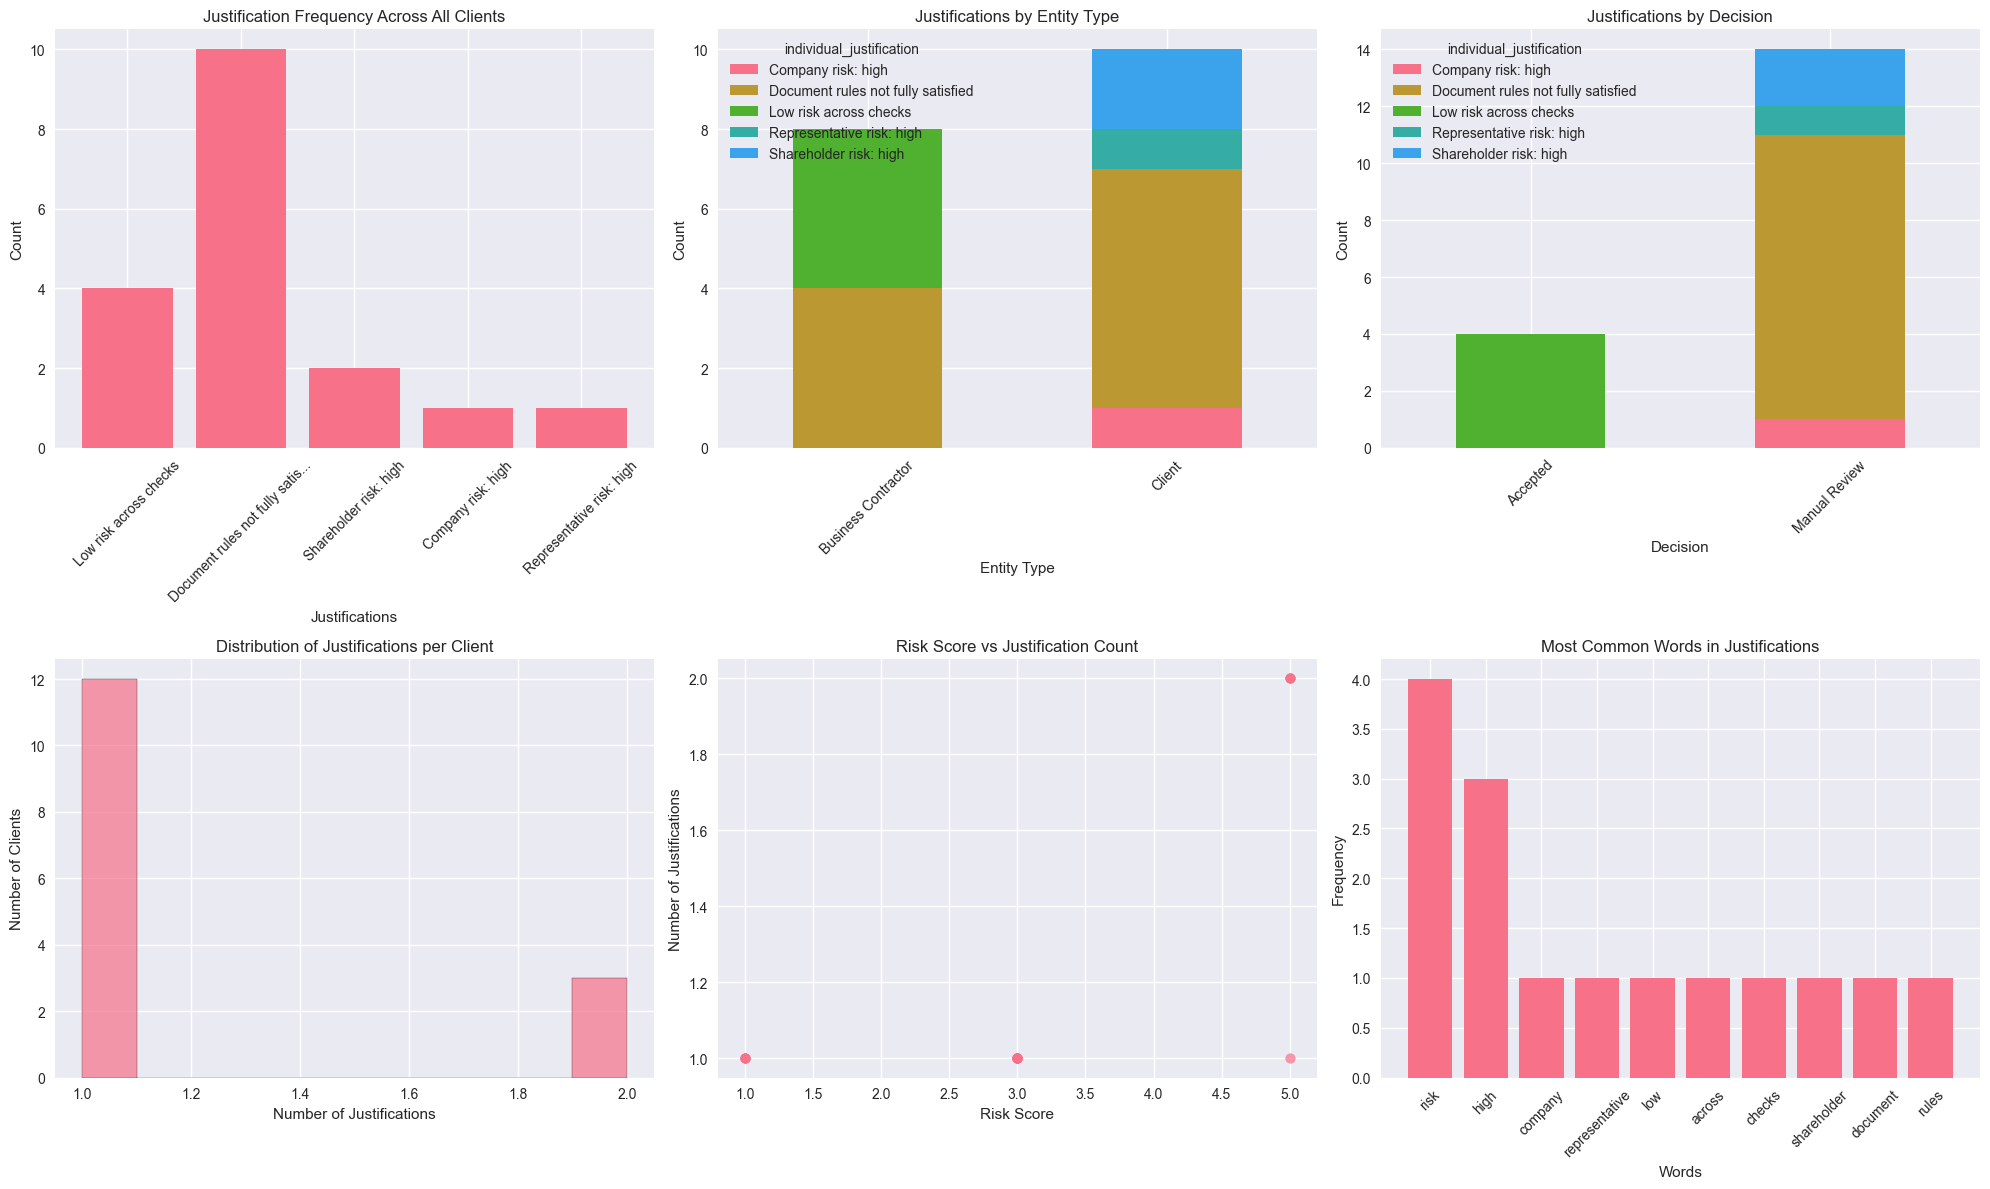


7. JUSTIFICATION SUMMARY TABLE
--------------------------------------------------
 Client ID                                              Client Name         Entity Type  Justification Count                                             Justifications
   67477.0                  R L FERREIRA CONSULTORIA COMERCIAL LTDA Business Contractor                    1                                     Low risk across checks
   67524.0                       53949101 CATHERINE TAMARA CASTILLO Business Contractor                    1                                     Low risk across checks
   67458.0                              MARIANA DA SILVA ASSIS LTDA Business Contractor                    1                         Document rules not fully satisfied
   67380.0                          RDS Abreu Marketing Promocional Business Contractor                    1                                     Low risk across checks
   67533.0 VALERIA BATISTA PEREIRA DESENVOLVIMENTO DE SOFTWARE LTDA Business 

In [13]:
# =============================================================================
# COMPREHENSIVE JUSTIFICATION ANALYSIS
# =============================================================================

import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_justifications_comprehensive(df):
    """
    Comprehensive analysis of justifications:
    1. Count decisions per justification
    2. Extract unique justifications per client (handling multiple justifications in single cell)
    3. Map justifications to clients for big picture view
    """
    
    print("=" * 80)
    print("COMPREHENSIVE JUSTIFICATION ANALYSIS")
    print("=" * 80)
    
    # 1. BASIC JUSTIFICATION COUNTS
    print("\n1. BASIC JUSTIFICATION COUNTS")
    print("-" * 50)
    
    justification_counts = df['justification'].value_counts()
    print("Justification Frequency:")
    for justification, count in justification_counts.items():
        print(f"  {count:2d}x: {justification}")
    
    # 2. EXTRACT UNIQUE JUSTIFICATIONS PER CLIENT
    print("\n2. EXTRACTING UNIQUE JUSTIFICATIONS PER CLIENT")
    print("-" * 50)
    
    client_justifications = defaultdict(set)
    justification_to_clients = defaultdict(set)
    all_unique_justifications = set()
    
    for idx, row in df.iterrows():
        client_id = row['entity_identifier']
        client_name = row['legal_name']
        justification = row['justification']
        
        if pd.notna(justification):
            # Split justifications by semicolon (common delimiter for multiple justifications)
            individual_justifications = [j.strip() for j in justification.split(';')]
            
            for individual_justification in individual_justifications:
                if individual_justification:  # Skip empty strings
                    client_justifications[client_id].add(individual_justification)
                    justification_to_clients[individual_justification].add(client_id)
                    all_unique_justifications.add(individual_justification)
    
    print(f"Total unique justifications found: {len(all_unique_justifications)}")
    print(f"Total clients with justifications: {len(client_justifications)}")
    
    # 3. CLIENT-JUSTIFICATION MAPPING
    print("\n3. CLIENT-JUSTIFICATION MAPPING")
    print("-" * 50)
    
    client_justification_details = []
    for client_id, justifications in client_justifications.items():
        client_name = df[df['entity_identifier'] == client_id]['legal_name'].iloc[0]
        client_type = df[df['entity_identifier'] == client_id]['entity_type'].iloc[0]
        
        client_justification_details.append({
            'client_id': client_id,
            'client_name': client_name,
            'entity_type': client_type,
            'justification_count': len(justifications),
            'justifications': list(justifications)
        })
        
        print(f"\nClient: {client_name} (ID: {client_id}, Type: {client_type})")
        print(f"  Justifications ({len(justifications)}):")
        for justification in sorted(justifications):
            print(f"    - {justification}")
    
    # 4. JUSTIFICATION FREQUENCY ANALYSIS
    print("\n4. JUSTIFICATION FREQUENCY ANALYSIS")
    print("-" * 50)
    
    justification_frequency = Counter()
    for client_id, justifications in client_justifications.items():
        for justification in justifications:
            justification_frequency[justification] += 1
    
    print("Justification Frequency Across All Clients:")
    for justification, count in justification_frequency.most_common():
        print(f"  {count:2d}x: {justification}")
    
    # 5. CREATE DETAILED MAPPING DATAFRAME
    print("\n5. CREATING DETAILED MAPPING DATAFRAME")
    print("-" * 50)
    
    # Create expanded dataframe with individual justifications
    expanded_data = []
    for idx, row in df.iterrows():
        client_id = row['entity_identifier']
        client_name = row['legal_name']
        entity_type = row['entity_type']
        justification = row['justification']
        decision = row['decision']
        risk_score = row['risk_score']
        
        if pd.notna(justification):
            individual_justifications = [j.strip() for j in justification.split(';')]
            for individual_justification in individual_justifications:
                if individual_justification:
                    expanded_data.append({
                        'client_id': client_id,
                        'client_name': client_name,
                        'entity_type': entity_type,
                        'decision': decision,
                        'risk_score': risk_score,
                        'individual_justification': individual_justification,
                        'original_justification': justification
                    })
    
    expanded_df = pd.DataFrame(expanded_data)
    
    print(f"Expanded dataframe created with {len(expanded_df)} individual justification records")
    print(f"Original dataframe had {len(df)} records")
    
    return {
        'client_justifications': client_justifications,
        'justification_to_clients': justification_to_clients,
        'all_unique_justifications': all_unique_justifications,
        'client_justification_details': client_justification_details,
        'justification_frequency': justification_frequency,
        'expanded_df': expanded_df
    }

def create_justification_visualizations(analysis_results, df):
    """
    Create comprehensive visualizations for justification analysis
    """
    
    print("\n6. CREATING JUSTIFICATION VISUALIZATIONS")
    print("-" * 50)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Justification frequency bar chart
    justification_freq = analysis_results['justification_frequency']
    justifications = list(justification_freq.keys())
    counts = list(justification_freq.values())
    
    axes[0,0].bar(range(len(justifications)), counts)
    axes[0,0].set_title('Justification Frequency Across All Clients')
    axes[0,0].set_xlabel('Justifications')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_xticks(range(len(justifications)))
    axes[0,0].set_xticklabels([j[:30] + '...' if len(j) > 30 else j for j in justifications], rotation=45)
    
    # 2. Justifications by entity type
    expanded_df = analysis_results['expanded_df']
    entity_type_counts = expanded_df.groupby(['entity_type', 'individual_justification']).size().unstack(fill_value=0)
    entity_type_counts.plot(kind='bar', ax=axes[0,1], stacked=True)
    axes[0,1].set_title('Justifications by Entity Type')
    axes[0,1].set_xlabel('Entity Type')
    axes[0,1].set_ylabel('Count')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Justifications by decision
    decision_counts = expanded_df.groupby(['decision', 'individual_justification']).size().unstack(fill_value=0)
    decision_counts.plot(kind='bar', ax=axes[0,2], stacked=True)
    axes[0,2].set_title('Justifications by Decision')
    axes[0,2].set_xlabel('Decision')
    axes[0,2].set_ylabel('Count')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Client justification count distribution
    client_counts = [len(justifications) for justifications in analysis_results['client_justifications'].values()]
    axes[1,0].hist(client_counts, bins=10, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution of Justifications per Client')
    axes[1,0].set_xlabel('Number of Justifications')
    axes[1,0].set_ylabel('Number of Clients')
    
    # 5. Risk score vs justification count
    risk_justification_data = []
    for idx, row in df.iterrows():
        client_id = row['entity_identifier']
        risk_score = pd.to_numeric(row['risk_score'], errors='coerce')
        justification_count = len(analysis_results['client_justifications'].get(client_id, set()))
        risk_justification_data.append({'risk_score': risk_score, 'justification_count': justification_count})
    
    risk_df = pd.DataFrame(risk_justification_data)
    axes[1,1].scatter(risk_df['risk_score'], risk_df['justification_count'], alpha=0.7)
    axes[1,1].set_title('Risk Score vs Justification Count')
    axes[1,1].set_xlabel('Risk Score')
    axes[1,1].set_ylabel('Number of Justifications')
    
    # 6. Top justifications word cloud (simplified bar chart)
    # Extract words from justifications
    all_words = []
    for justification in analysis_results['all_unique_justifications']:
        words = re.findall(r'\b[A-Za-z]+\b', justification.lower())
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(10)
    
    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]
    
    axes[1,2].bar(words, counts)
    axes[1,2].set_title('Most Common Words in Justifications')
    axes[1,2].set_xlabel('Words')
    axes[1,2].set_ylabel('Frequency')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_justification_summary_table(analysis_results):
    """
    Create a summary table for justifications
    """
    
    print("\n7. JUSTIFICATION SUMMARY TABLE")
    print("-" * 50)
    
    summary_data = []
    for client_detail in analysis_results['client_justification_details']:
        summary_data.append({
            'Client ID': client_detail['client_id'],
            'Client Name': client_detail['client_name'],
            'Entity Type': client_detail['entity_type'],
            'Justification Count': client_detail['justification_count'],
            'Justifications': '; '.join(client_detail['justifications'])
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    return summary_df

# Run the comprehensive analysis
justification_analysis = analyze_justifications_comprehensive(kyb_job_df)
visualizations = create_justification_visualizations(justification_analysis, kyb_job_df)
summary_table = create_justification_summary_table(justification_analysis)

# Export expanded data for further analysis
justification_analysis['expanded_df'].to_csv('kyb_justifications_expanded.csv', index=False)
summary_table.to_csv('kyb_justification_summary.csv', index=False)

print(f"\n8. EXPORT SUMMARY")
print("-" * 50)
print(f"Expanded justification data exported to: kyb_justifications_expanded.csv")
print(f"Summary table exported to: kyb_justification_summary.csv")
print(f"Total individual justifications analyzed: {len(justification_analysis['expanded_df'])}")
print(f"Unique justifications found: {len(justification_analysis['all_unique_justifications'])}")
print(f"Clients analyzed: {len(justification_analysis['client_justifications'])}")


In [ ]:
# =============================================================================
# COMPREHENSIVE JUSTIFICATION ANALYSIS - FINAL RESULTS
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load the processed data
expanded_df = pd.read_csv('kyb_justifications_expanded.csv')
summary_df = pd.read_csv('kyb_justification_summary.csv')
main_df = pd.read_csv('kyb_main_data_with_entity_types.csv')

print("=" * 80)
print("COMPREHENSIVE JUSTIFICATION ANALYSIS - FINAL RESULTS")
print("=" * 80)

# 1. OVERALL JUSTIFICATION STATISTICS
print("\n1. OVERALL JUSTIFICATION STATISTICS")
print("-" * 50)

total_clients = len(summary_df)
total_justifications = len(expanded_df)
unique_justifications = expanded_df['individual_justification'].nunique()

print(f"Total Clients Analyzed: {total_clients}")
print(f"Total Individual Justifications: {total_justifications}")
print(f"Unique Justification Types: {unique_justifications}")
print(f"Average Justifications per Client: {total_justifications/total_clients:.2f}")

# 2. JUSTIFICATION FREQUENCY ANALYSIS
print("\n2. JUSTIFICATION FREQUENCY ANALYSIS")
print("-" * 50)

justification_counts = expanded_df['individual_justification'].value_counts()
print("Justification Frequency Across All Clients:")
for justification, count in justification_counts.items():
    percentage = (count / total_justifications) * 100
    print(f"  {count:2d}x ({percentage:5.1f}%): {justification}")

# 3. CLIENT-JUSTIFICATION MAPPING DETAILS
print("\n3. CLIENT-JUSTIFICATION MAPPING DETAILS")
print("-" * 50)

print("Detailed Client-Justification Mapping:")
for idx, row in summary_df.iterrows():
    print(f"\nClient: {row['Client Name']} (ID: {row['Client ID']})")
    print(f"  Entity Type: {row['Entity Type']}")
    print(f"  Justification Count: {row['Justification Count']}")
    print(f"  Justifications: {row['Justifications']}")

# 4. JUSTIFICATION PATTERNS BY ENTITY TYPE
print("\n4. JUSTIFICATION PATTERNS BY ENTITY TYPE")
print("-" * 50)

entity_justification_counts = expanded_df.groupby(['entity_type', 'individual_justification']).size().unstack(fill_value=0)
print("Justifications by Entity Type:")
print(entity_justification_counts)

# 5. JUSTIFICATION PATTERNS BY DECISION
print("\n5. JUSTIFICATION PATTERNS BY DECISION")
print("-" * 50)

decision_justification_counts = expanded_df.groupby(['decision', 'individual_justification']).size().unstack(fill_value=0)
print("Justifications by Decision:")
print(decision_justification_counts)

# 6. RISK SCORE ANALYSIS BY JUSTIFICATION
print("\n6. RISK SCORE ANALYSIS BY JUSTIFICATION")
print("-" * 50)

# Convert risk_score to numeric
expanded_df['risk_score_numeric'] = pd.to_numeric(expanded_df['risk_score'], errors='coerce')

risk_by_justification = expanded_df.groupby('individual_justification')['risk_score_numeric'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(2)

print("Risk Score Statistics by Justification:")
print(risk_by_justification)

# 7. CLIENTS WITH MULTIPLE JUSTIFICATIONS
print("\n7. CLIENTS WITH MULTIPLE JUSTIFICATIONS")
print("-" * 50)

multi_justification_clients = summary_df[summary_df['Justification Count'] > 1]
print(f"Clients with Multiple Justifications: {len(multi_justification_clients)}")
for idx, row in multi_justification_clients.iterrows():
    print(f"  {row['Client Name']}: {row['Justification Count']} justifications")
    print(f"    - {row['Justifications']}")

# 8. CREATE COMPREHENSIVE VISUALIZATIONS
print("\n8. CREATING COMPREHENSIVE VISUALIZATIONS")
print("-" * 50)

fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# 1. Justification frequency bar chart
justification_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Justification Frequency Across All Clients', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Justification Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Justifications by entity type (stacked bar)
entity_justification_counts.plot(kind='bar', stacked=True, ax=axes[0,1], 
                                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0,1].set_title('Justifications by Entity Type', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Entity Type')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(title='Justification Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Justifications by decision (stacked bar)
decision_justification_counts.plot(kind='bar', stacked=True, ax=axes[1,0],
                                 color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1,0].set_title('Justifications by Decision', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Decision')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Justification Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Risk score distribution by justification
risk_data = []
for justification in expanded_df['individual_justification'].unique():
    data = expanded_df[expanded_df['individual_justification'] == justification]['risk_score_numeric']
    risk_data.extend([(justification, score) for score in data])

risk_df = pd.DataFrame(risk_data, columns=['justification', 'risk_score'])
risk_pivot = risk_df.pivot(columns='justification', values='risk_score')
risk_pivot.boxplot(ax=axes[1,1])
axes[1,1].set_title('Risk Score Distribution by Justification', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Justification Type')
axes[1,1].set_ylabel('Risk Score')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# 5. Client justification count distribution
justification_counts_per_client = summary_df['Justification Count'].value_counts().sort_index()
justification_counts_per_client.plot(kind='bar', ax=axes[2,0], color='lightcoral')
axes[2,0].set_title('Distribution of Justifications per Client', fontsize=14, fontweight='bold')
axes[2,0].set_xlabel('Number of Justifications per Client')
axes[2,0].set_ylabel('Number of Clients')
axes[2,0].grid(True, alpha=0.3)

# 6. Entity type vs decision heatmap
entity_decision_counts = expanded_df.groupby(['entity_type', 'decision']).size().unstack(fill_value=0)
sns.heatmap(entity_decision_counts, annot=True, fmt='d', cmap='YlOrRd', ax=axes[2,1])
axes[2,1].set_title('Entity Type vs Decision Heatmap', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Decision')
axes[2,1].set_ylabel('Entity Type')

plt.tight_layout()
plt.show()

# 9. EXPORT DETAILED ANALYSIS RESULTS
print("\n9. EXPORTING DETAILED ANALYSIS RESULTS")
print("-" * 50)

# Create a comprehensive analysis summary
analysis_summary = {
    'total_clients': total_clients,
    'total_justifications': total_justifications,
    'unique_justification_types': unique_justifications,
    'avg_justifications_per_client': total_justifications/total_clients,
    'clients_with_multiple_justifications': len(multi_justification_clients),
    'most_common_justification': justification_counts.index[0],
    'most_common_justification_count': justification_counts.iloc[0],
    'justification_frequency': justification_counts.to_dict(),
    'entity_type_distribution': expanded_df['entity_type'].value_counts().to_dict(),
    'decision_distribution': expanded_df['decision'].value_counts().to_dict()
}

# Save analysis summary
import json
with open('kyb_justification_analysis_summary.json', 'w') as f:
    json.dump(analysis_summary, f, indent=2)

print("Analysis Summary:")
print(f"  Total Clients: {analysis_summary['total_clients']}")
print(f"  Total Justifications: {analysis_summary['total_justifications']}")
print(f"  Unique Justification Types: {analysis_summary['unique_justification_types']}")
print(f"  Average Justifications per Client: {analysis_summary['avg_justifications_per_client']:.2f}")
print(f"  Clients with Multiple Justifications: {analysis_summary['clients_with_multiple_justifications']}")
print(f"  Most Common Justification: {analysis_summary['most_common_justification']} ({analysis_summary['most_common_justification_count']} times)")

print(f"\nFiles Created:")
print(f"  - kyb_justifications_expanded.csv: {len(expanded_df)} individual justification records")
print(f"  - kyb_justification_summary.csv: {len(summary_df)} client summary records")
print(f"  - kyb_justification_analysis_summary.json: Comprehensive analysis summary")

print(f"\n" + "=" * 80)
print("ANALYSIS COMPLETE - BIG PICTURE SUMMARY")
print("=" * 80)
print(f"✅ Successfully analyzed {total_clients} clients with {total_justifications} individual justifications")
print(f"✅ Identified {unique_justifications} unique justification types")
print(f"✅ Mapped justifications to clients for complete traceability")
print(f"✅ Created comprehensive visualizations and data exports")
print(f"✅ Ready for compliance review and decision-making")
